In [21]:
from LogErrLoader import LoadDNDSLogErr
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import re
from scipy.ndimage import uniform_filter1d
import scienceplots

plt.style.use(["science"])
font = {"size": 12}

matplotlib.rc("font", **font)
lwc = 0.5
msc = 5
markEvery = 500
markerList = (
    ".",
    "s",
    "o",
    "v",
    "^",
    "<",
    ">",
    "8",
    "p",
    "*",
    "h",
    "H",
    "D",
    "d",
    "P",
    "X",
)
format = "pdf"


def windowed_std(arr, window_size: int):
    mean = uniform_filter1d(arr, size=window_size, mode="reflect")
    mean_sq = uniform_filter1d(arr**2, size=window_size, mode="reflect")
    std = np.sqrt(mean_sq - mean**2)
    return std[0:-window_size]


base = "CRM_0_VRes"
out_name = "pics/crm_noDri_VRes_MG"
name_map = {
    "O4_0_NoDriVRes_MG4jc2-4jc2-cor": "gmres5x1ilu-4ilu-4ilu",
    "O4_0_NoDriVRes_MG4jc2-4jc2": "gmres5x1ilu-4ilu",
    "O4_0_NoDriVRes": "gmres5x1ilu",
}

# series = ["all", "ilu", "lusgs", "gmres"]
series = ["all"]
tRanges = [70000]
# tRanges = [None]

log_names = os.listdir(base)
log_names.sort(key=lambda s: (len(s), s))
log_names = list(filter(lambda s: s.endswith(".log"), log_names))
print(log_names)
data_list = []
data_list_resMaxes = {}
for log in log_names:
    m = re.match(r"([\w-]+)_.log", log)
    name = m.group(1)
    if name in name_map.keys():
        name = name_map[name]
    else:
        continue
    data = LoadDNDSLogErr(os.path.join(base, log))
    data_list.append((data, name))
    for key in data:
        max_v = np.array(data[key]).max()
        if key.startswith("res"):
            data_list_resMaxes[key] = (
                max(data_list_resMaxes[key], max_v)
                if key in data_list_resMaxes.keys()
                else max_v
            )
for data, name in data_list:
    print(name)

label_map = {
    "ilu": "ILU",
    "gmres5x1": "GMRES+",
    "lusgs": "LUSGS",
}


def name_mapper(name: str):
    for a, b in label_map.items():
        name = name.replace(a, b)
    return name


def plotOne(data, label, plotIndex=0, xAxis="tWall", yAxis="res0", std=0):
    color_seq = matplotlib.color_sequences["tab10"]
    dataY = np.array(data[yAxis][0:-1])
    dataX = np.array(data[xAxis][0:-1])

    if std > 0:
        dataY = windowed_std(dataY, std)
        dataX = dataX[0 : len(dataY)]
    if yAxis.startswith("res"):
        dataY /= data_list_resMaxes[yAxis]
    if xAxis == "tWall":
        dataX -= dataX[0]
    plt.plot(
        dataX,
        dataY,
        label=label,
        lw=lwc,
        marker=markerList[plotIndex],
        markevery=markEvery,
        markersize=msc,
        markeredgewidth=lwc,
        markerfacecolor="none",
        color=color_seq[plotIndex % len(color_seq)],
    )
    return plotIndex + 1


def plotAfter(
    xlim,
    xlabel="t",
    ylabel="res0",
    logy=True,
    leg_params={
        # "facecolor": "red",
        "frameon": True,
        "edgecolor": "none",
        "framealpha": 0.5,
    },
):
    if logy:
        plt.yscale("log")
    leg = plt.legend(fontsize=9, **leg_params)
    plt.xlim(xlim)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(visible=True, which="both", alpha=0.3)

['O4_0_NoDriVRes_.log', 'O4_0_NoDriVRes_MG4jc2_.log', 'O4_0_NoDriVRes_stalled_.log', 'O4_0_NoDriVRes_MG4jc2-4jc2_.log', 'O4_0_NoDriVRes_MG4jc2-4jc2-cor_.log']
gmres5x1ilu
gmres5x1ilu-4ilu
gmres5x1ilu-4ilu-4ilu


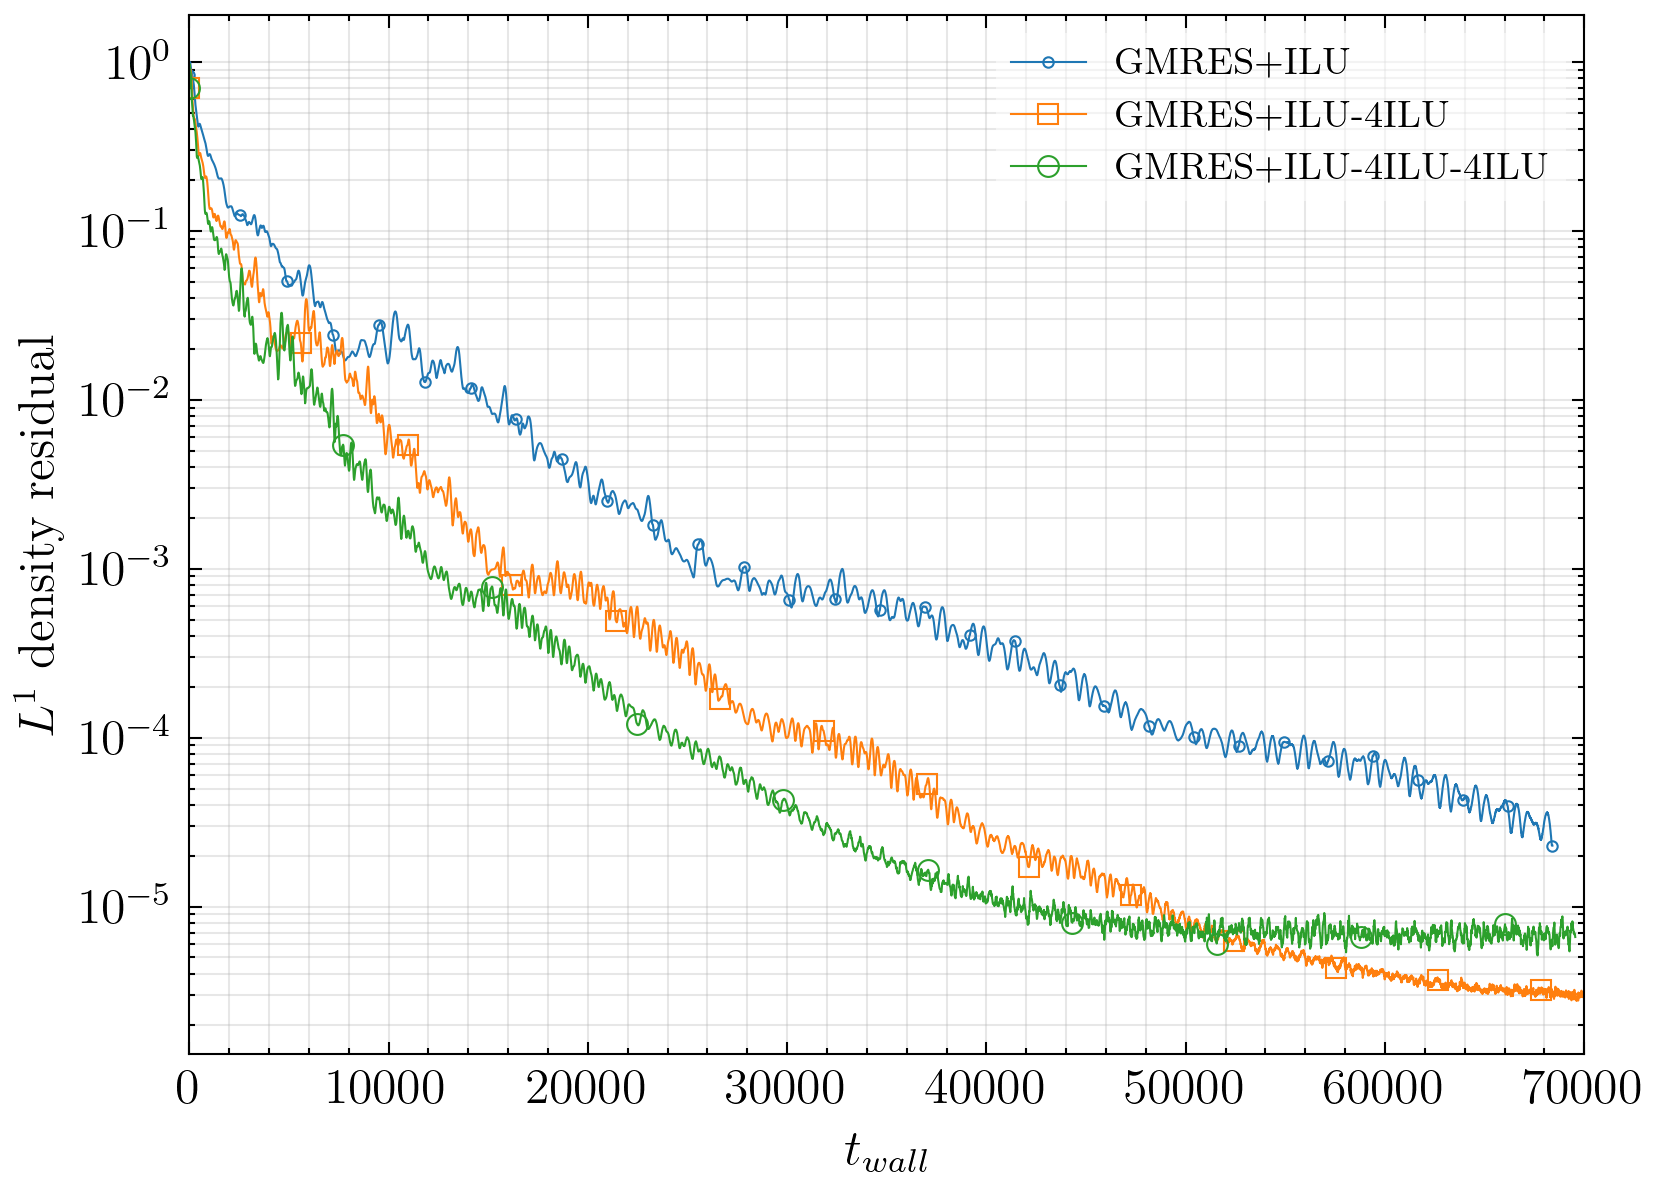

In [22]:
for ifig, subset in enumerate(series):
    if subset == "all":
        head = ""
    else:
        head = subset

    plt.figure(1003 + 10000*ifig,figsize=(6, 4.5), dpi=300)
    # plt.title(f"AOA 15, res-time, {subset}")
    for i, (data, name) in enumerate(data_list):
        if name.startswith(head):
            plotOne(data, name_mapper(name), i, xAxis="tWall", yAxis="res0")
    plotAfter(
        (0, tRanges[ifig]), xlabel=r"$t_{wall}$", ylabel=r"$L^1$ density residual"
    )
    plt.savefig(f"{out_name}_rt_{subset}.{format}", format=format)

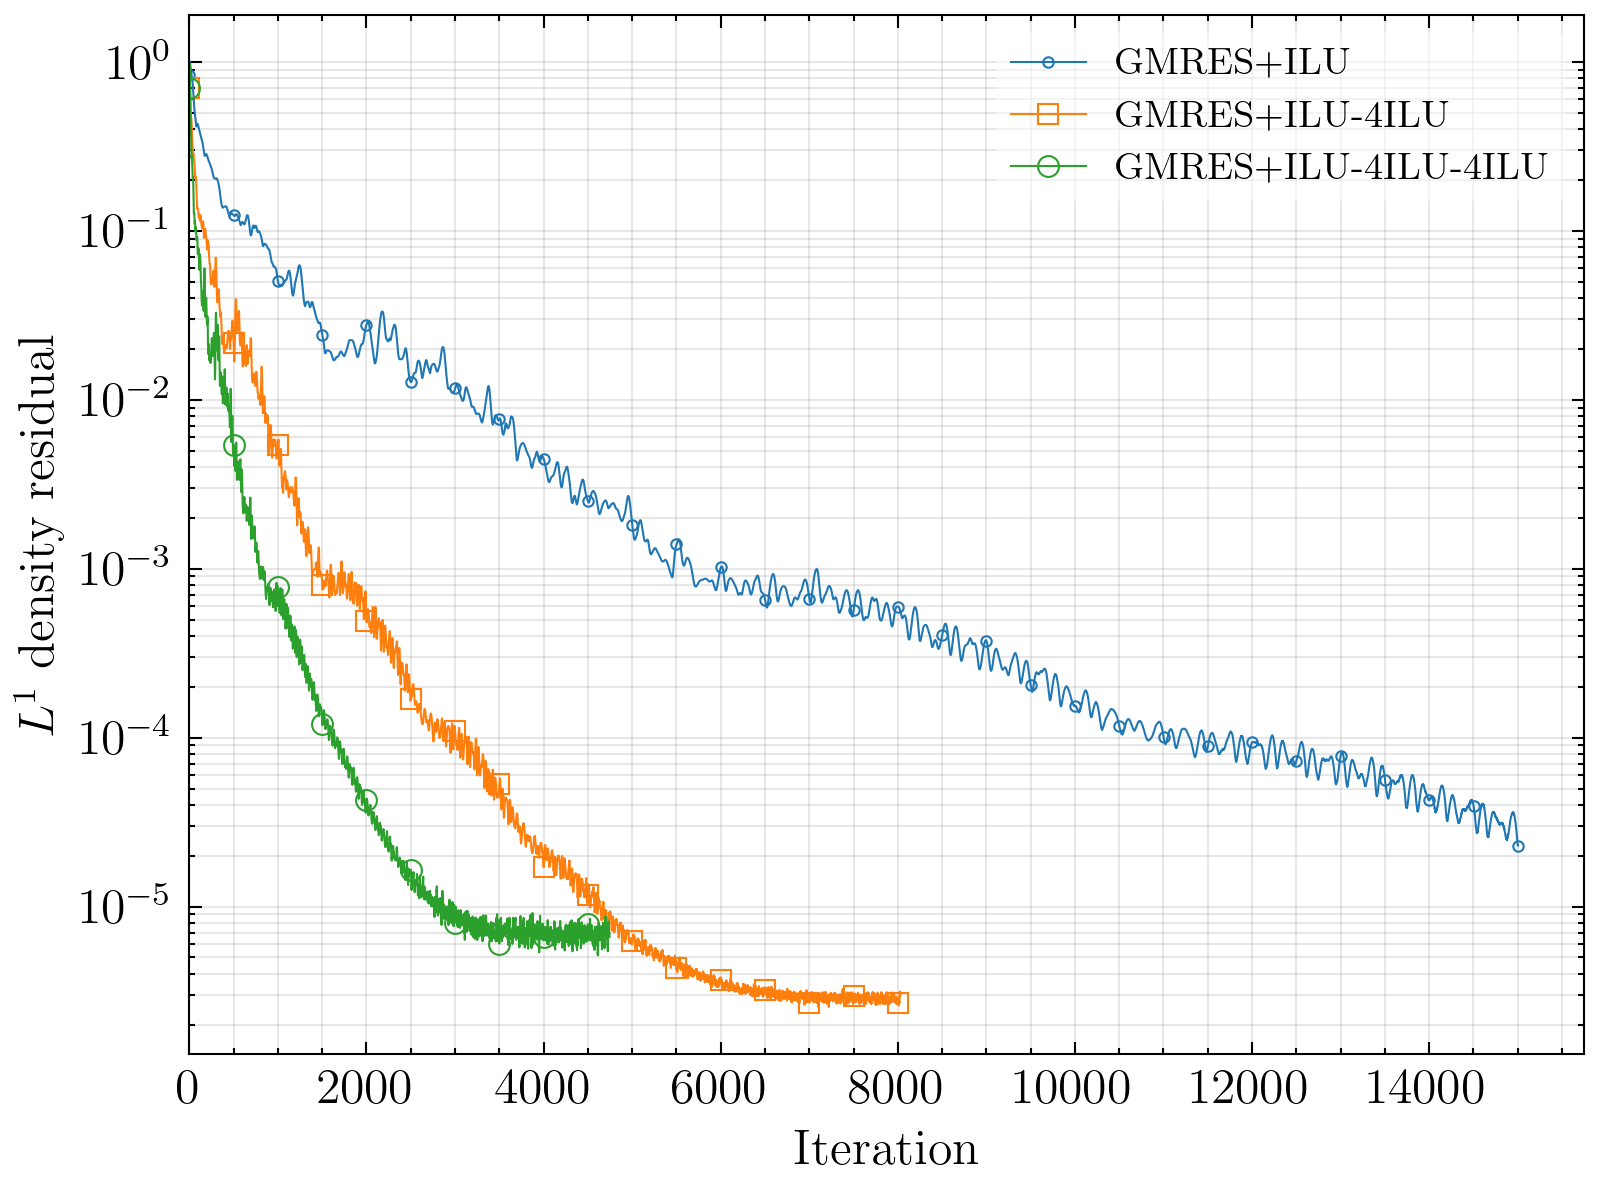

In [23]:
plt.figure(1004, figsize=(6, 4.5), dpi=300)
# plt.title("AOA 15, res-niter")
for i, (data, name) in enumerate(data_list):
    plotOne(data, name_mapper(name), i, xAxis="iter", yAxis="res0")
plotAfter((0, None), xlabel="Iteration", ylabel=r"$L^1$ density residual")
plt.savefig(f"{out_name}_ri_{"all"}.{format}", format=format)

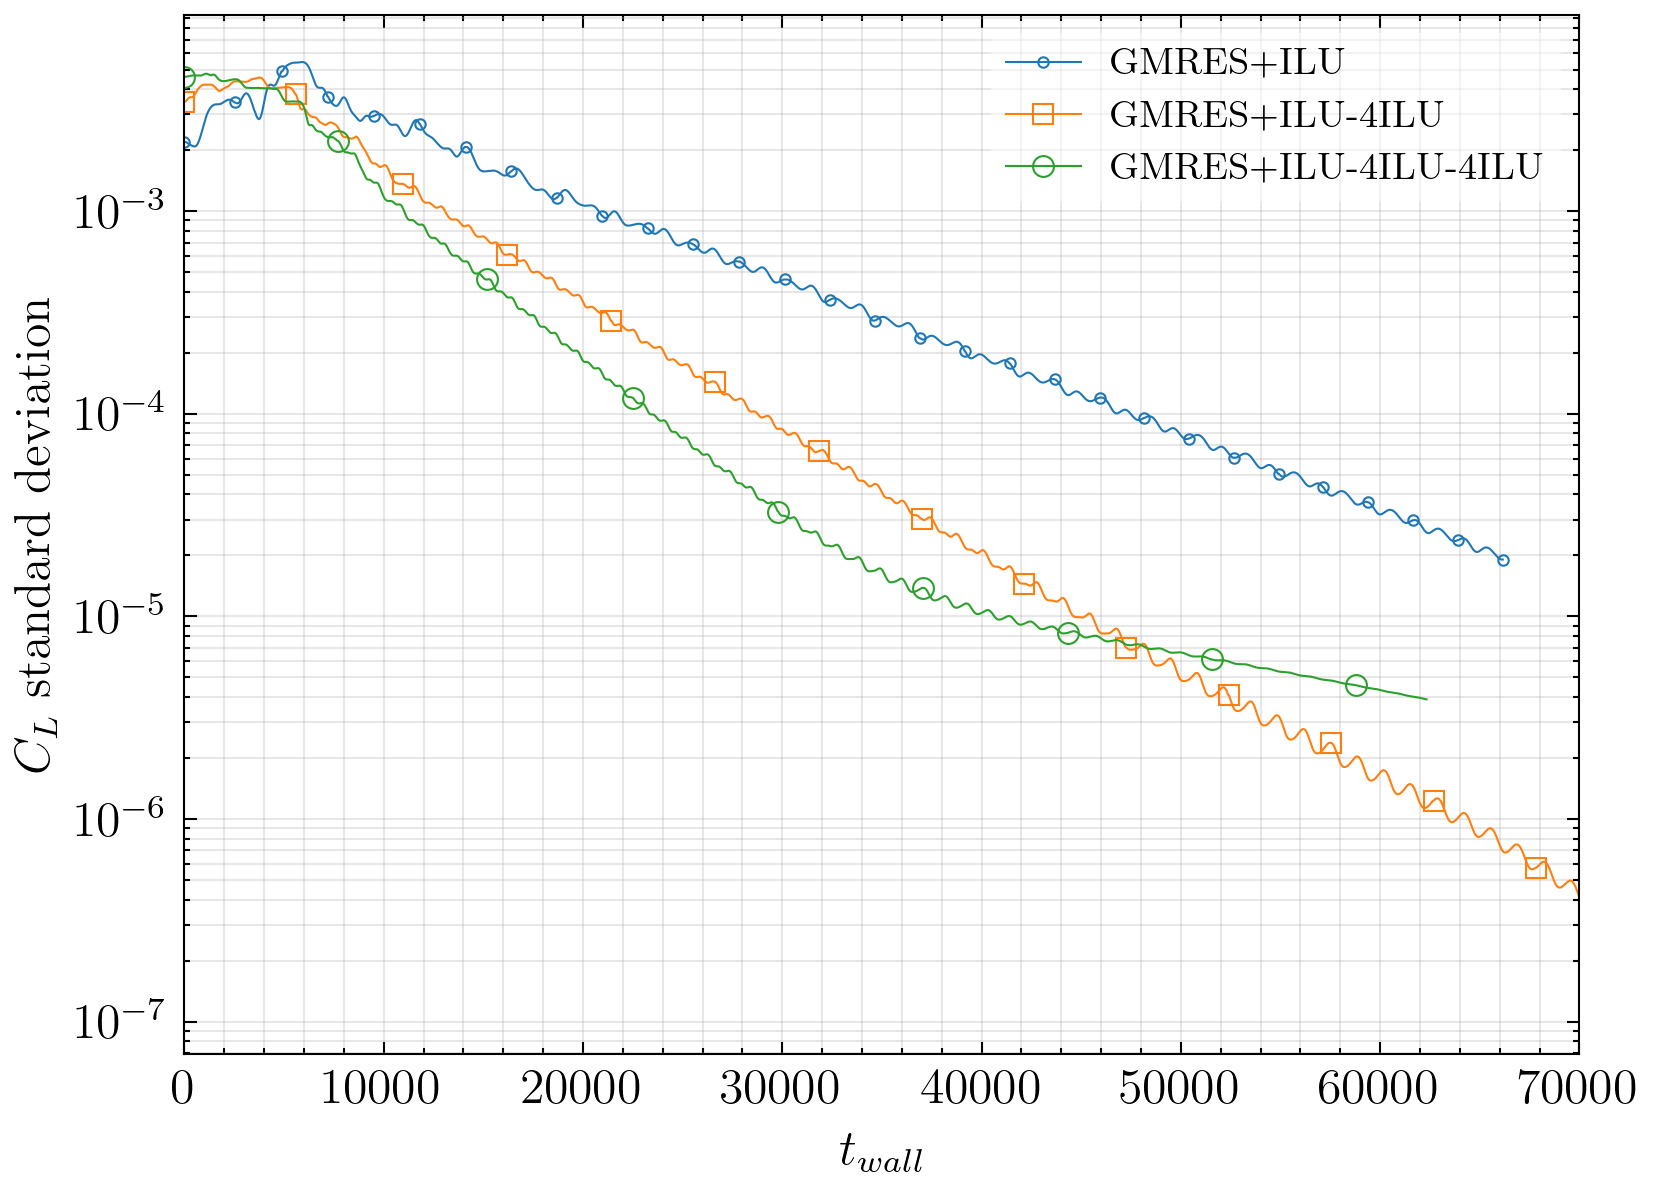

In [24]:
for ifig, subset in enumerate(series):
    if subset == "all":
        head = ""
    else:
        head = subset

    plt.figure(1005 + 10000 * ifig, figsize=(6, 4.5), dpi=300)
    # plt.title(f"AOA 15, CL std-time, {subset}")
    for i, (data, name) in enumerate(data_list):
        if name.startswith(head):
            plotOne(data, name_mapper(name), i, xAxis="tWall", yAxis="CL", std=500)
    plotAfter(
        (0, tRanges[ifig]), xlabel=r"$t_{wall}$", ylabel=r"$C_L$ standard deviation"
    )
    plt.savefig(f"{out_name}_clstdT_{subset}.{format}")

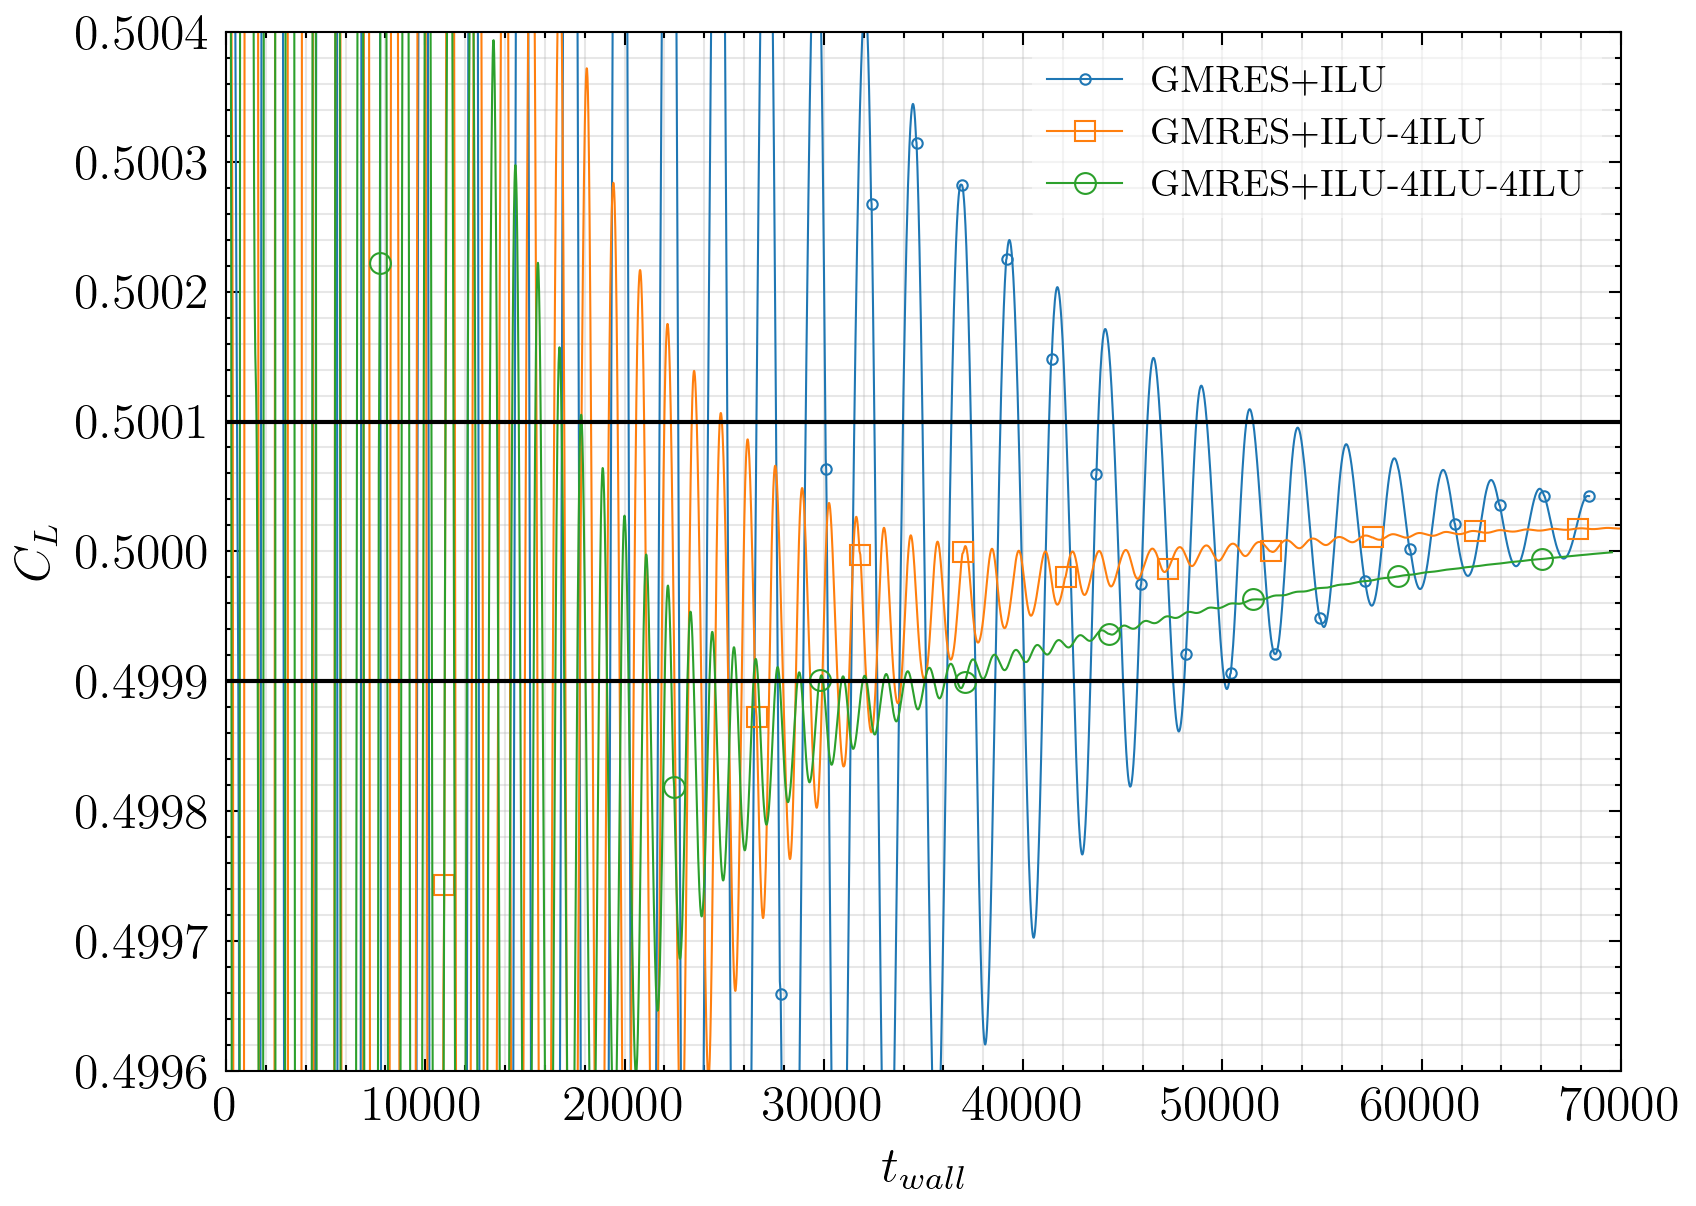

In [25]:
for ifig, subset in enumerate(series):
    if subset == "all":
        head = ""
    else:
        head = subset

    plt.figure(1005 + 10000 * ifig, figsize=(6, 4.5), dpi=300)
    # plt.title(f"AOA 15, CL-time, {subset}")
    for i, (data, name) in enumerate(data_list):
        if name.startswith(head):
            plotOne(data, name_mapper(name), i, xAxis="tWall", yAxis="CL")
    plotAfter((0, tRanges[ifig]), xlabel=r"$t_{wall}$", ylabel=r"$C_L$", logy=False)
    plt.plot([0,1e10,1e10,0], np.array([1,1,-1,-1]) * 1e-4 + 0.5, c="k", lw = 1)
    plt.ylim(np.array([-1,1]) * 4e-4 + 0.5)
    plt.savefig(f"{out_name}_cl_{subset}.{format}")